# DATA ANALYSIS WITH PANDAS - DAY 19 - WEEK 4

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import difflib # To take closest matches to countries

Have to import module **`us`** to filter data of incidents because if the incident happened in the USA, it will be registred by `county` and `State`<br>
[US MODULE](https://github.com/unitedstates/python-us)

In [2]:
import us
# USA States names in lowercase - Using US module
USstates=[item.name for item in us.STATES]
states = list(us.states.mapping('name', 'abbr').values())

Also I have to import **`pycounrty`** module to check countries

In [3]:
import pycountry
# List of countries
countrylist=[str(country.name) for country in pycountry.countries]

In [4]:
def month_number_to_string(string):
    m = {
        '01':'jan','02':'feb','03':'mar','04':'apr','05':'may','06':'jun',
         '07':'jul','08':'aug','09':'sep','10':'oct','11':'nov','12':'dec'
        }
    s = string.strip()[:3].lower()
    try:
        out = m[s]
        return out
    except:
        raise ValueError('Not a month')

## Data set: Airplane Crashes and Fatalities since 1908
I have retrieved the data from the link below<br>
https://opendata.socrata.com/Government/Airplane-Crashes-and-Fatalities-Since-1908/q2te-8cvq

In [5]:
crashes_raw=pd.read_csv('Airplane_Crashes_and_Fatalities_Since_1908.csv')
# Drop Description Attribute
crashes_raw=crashes_raw.drop('Summary',axis=1)

# Cleaning dataframe attibute date. I will select month and year for its further use
dates=[[month_number_to_string(item.split('/')[0]),int(item.split('/')[0]),item.split('/')[2]] for item in crashes_raw['Date']]
crashes_1=pd.concat((crashes_raw,pd.DataFrame(dates,columns=['Month','Month Num','Year'])),axis=1)
colist=crashes_1.columns.tolist()[-3:]+crashes_1.columns.tolist()[2:-3]
crashes_1=crashes_1[colist]
crashes_1['Year']=crashes_1['Year'].astype('int64')

In [6]:
info=crashes_1.describe(include='all').T
info['Data Type']=crashes_1.dtypes
display(info.T)

,Month,Month Num,Year,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground
count,5268,5268,5268,5248,5250,1069,3562,5241,4933,4040,5246,5256,5246
unique,12,NaN,NaN,4303,2476,724,3244,2446,4905,3707,NaN,NaN,NaN
top,dec,NaN,NaN,"Sao Paulo, Brazil",Aeroflot,-,Training,Douglas DC-3,49,178,NaN,NaN,NaN
freq,517,NaN,NaN,15,179,67,81,334,3,6,NaN,NaN,NaN
mean,NaN,6.64389,1971.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.5545,20.0683,1.60884
std,NaN,3.54616,22.3875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0767,33.2,53.9878
min,NaN,1,1908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
25%,NaN,3,1954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,3,0
50%,NaN,7,1973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,9,0
75%,NaN,10,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30,23,0


Now I am going to normalize data from location and transport type ('Civilian' or 'Military')

In [7]:
# First by countries
# Had to use weighted comparisions because country and states name weren't correct
# Done with module difflib and function get_close_matches - Very handy
listcountries=[]
for item in crashes_1['Location']:
    if str(item).split(',')[-1].strip() not in USstates and str(item).split(',')[-1].strip() in countrylist:
        listcountries.append(str(item).split(',')[-1].strip())
    elif str(item).split(',')[-1].strip() in USstates:
        listcountries.append('United States')
    else:
        ap=[]
        for e in re.findall('\w+',str(item).replace(',','')):
            al=difflib.get_close_matches(str(e),countrylist,n=1)
            if al!=[]:
                ap.append(al[0])
            else:
                al1=difflib.get_close_matches(str(e).capitalize(),USstates,n=1)
                al2=difflib.get_close_matches(str(e).capitalize(),states,n=1,cutoff=0.5)
                if al1!=[] or al2!=[]:
                    ap.append('United States')                    

        if ap!=[]:
            listcountries.append(ap[0])
        else:
            listcountries.append(str(item))
    
airtype=[]
for item in crashes_1['Operator']:
    if 'Military' in str(item):
        airtype.append('Military')
    else:
        airtype.append('Civil')

crashes_2=crashes_1[['Month','Month Num','Year','Aboard','Fatalities','Ground']].copy()
crashes_2['Country']=listcountries
crashes_2['Type']=airtype
crashes_2=crashes_2[['Year','Month','Month Num','Country','Type','Aboard','Fatalities','Ground']]


In [8]:
# Clean Data Frame for crashes for locations out of each country, Water Crashes
crashes_L=crashes_2[crashes_2['Country'].isin(countrylist)].reset_index(drop=True)

# Data Frame for only crashes out of land
crashes_W=crashes_2[~crashes_2['Country'].isin(countrylist)].reset_index(drop=True)

print("")
print("Land crashes")
display(crashes_L.head(5))
print("")
print("Water crashes")
display(crashes_W.head(5))


Land crashes


,Year,Month,Month Num,Country,Type,Aboard,Fatalities,Ground
0,1908,sep,9,United States,Military,2.0,1.0,0.0
1,1912,jul,7,United States,Military,5.0,5.0,0.0
2,1913,aug,8,Canada,Civil,1.0,1.0,0.0
3,1913,sep,9,Serbia,Military,20.0,14.0,0.0
4,1913,oct,10,Germany,Military,30.0,30.0,0.0



Water crashes


,Year,Month,Month Num,Country,Type,Aboard,Fatalities,Ground
0,1918,apr,4,Over the Mediterranean,Military,23.0,23.0,0.0
1,1919,oct,10,English Channel,Civil,NaN,NaN,NaN
2,1924,apr,4,Over the English Channel,Civil,3.0,3.0,0.0
3,1926,may,5,English Channel,Civil,1.0,1.0,0.0
4,1926,oct,10,English Channel,Civil,12.0,0.0,0.0


Pivoting the table for land crashes

In [9]:
# Pivoted_1 contains info of how many fatalities and people aboard were in all flights for eache year
# Also counts the number of incidents per year
pivoted_1=(crashes_L.pivot_table(index=['Year'],aggfunc=({'Country':'count','Fatalities':'sum','Aboard':'sum'}))).reset_index()
pivoted_1['Year']=pivoted_1['Year'].astype('int64')
pivoted_1.columns=['Year','People aboard','# Crashes','Fatalities']
pivoted_1=pivoted_1[['Year','# Crashes','People aboard','Fatalities']]
display(pivoted_1.dtypes)
display(pivoted_1.head())
display(pivoted_1.tail())

Year               int64
# Crashes          int64
People aboard    float64
Fatalities       float64
dtype: object

,Year,# Crashes,People aboard,Fatalities
0,1908,1,2.0,1.0
1,1912,1,5.0,5.0
2,1913,3,51.0,45.0
3,1915,2,60.0,40.0
4,1916,5,109.0,108.0


,Year,# Crashes,People aboard,Fatalities
93,2005,49,2151.0,1293.0
94,2006,49,1413.0,1136.0
95,2007,54,1364.0,931.0
96,2008,61,1445.0,802.0
97,2009,24,891.0,581.0


___

### CASE #1
Hypothesis: There has to exists a linear relation between `people aboard` a plane and the number of `fatalities`<br>
This is common sense driven, when planes crash while flying almost everybody die.<br>
Of course, the `# of crashes` has also a strong relationship with `fatalities` and `people aboard`<br>

Lets correlate this info<br>
First: **Pearson Correlation**<br>
* ```Let's check if our variables have any linear relation with each other```

In [10]:
pivoted_1.corr()

,Year,# Crashes,People aboard,Fatalities
Year,1.000000,0.758250,0.778644,0.734575
# Crashes,0.758250,1.000000,0.909307,0.919632
People aboard,0.778644,0.909307,1.000000,0.971843
Fatalities,0.734575,0.919632,0.971843,1.000000


Second: **Spearman Correlation Coeficients**<br>
* ```Let's check if our variables have any non-linear relation with each other```

In [11]:
pivoted_1.corr(method='spearman')

,Year,# Crashes,People aboard,Fatalities
Year,1.000000,0.711885,0.778939,0.734006
# Crashes,0.711885,1.000000,0.914795,0.921137
People aboard,0.778939,0.914795,1.000000,0.966652
Fatalities,0.734006,0.921137,0.966652,1.000000


Second: **Kendall Correlation Coeficients**<br>
* ```Let's check if our variables have any non-parametric relation with each other```

In [12]:
pivoted_1.corr(method='kendall')

,Year,# Crashes,People aboard,Fatalities
Year,1.000000,0.536793,0.608796,0.551405
# Crashes,0.536793,1.000000,0.756193,0.761772
People aboard,0.608796,0.756193,1.000000,0.883907
Fatalities,0.551405,0.761772,0.883907,1.000000


### Conclusions - 1

Kendall is the worst one for this dataset. So we can depict it.<br>
Spearman and Pearson shows good correlation coeficients for variables within the dataframe<br>
Our hipothesis is confirmed by the results driven by spearman and pearson coeficients.<br>
There are a strong relationship between all variables except for the year. This one does not reach a value over <br>
0.8 so It is not good enough for us.<br>

___

### CASE #2
Now lets check the same correlations between years, people aboard, ground fatalities and plane fatalities <br>
for the following data frame (Land crashes). These could be related with each other

In [13]:
crashes_L['Year']=crashes_L['Year'].astype('int64')
crashes_L=crashes_L.sort_values('Year',ascending=True).reset_index(drop=True)
display(crashes_L.head())
display(crashes_L.tail())

,Year,Month,Month Num,Country,Type,Aboard,Fatalities,Ground
0,1908,sep,9,United States,Military,2.0,1.0,0.0
1,1912,jul,7,United States,Military,5.0,5.0,0.0
2,1913,aug,8,Canada,Civil,1.0,1.0,0.0
3,1913,sep,9,Serbia,Military,20.0,14.0,0.0
4,1913,oct,10,Germany,Military,30.0,30.0,0.0


,Year,Month,Month Num,Country,Type,Aboard,Fatalities,Ground
5195,2009,jan,1,United States,Civil,155.0,0.0,0.0
5196,2009,jan,1,Niger,Civil,9.0,8.0,0.0
5197,2009,jun,6,Canada,Civil,1.0,1.0,0.0
5198,2009,mar,3,United States,Civil,14.0,14.0,0.0
5199,2009,jun,6,India,Military,13.0,13.0,0.0


For this one I am not going to group or pivot the table<br><br>
Lets see those correlation coeficients!

In [14]:
print('')
print('Pearson Coeficients')
display(crashes_L.corr())
print('------------------------------')
print('')
print('Spearman Coeficients:')
display(crashes_L.corr(method='spearman'))
print('------------------------------')
print('')
print('Kendall Coeficients:')
display(crashes_L.corr(method='kendall'))


Pearson Coeficients


,Year,Month Num,Aboard,Fatalities,Ground
Year,1.000000,-0.027796,0.152727,0.109285,0.029286
Month Num,-0.027796,1.000000,0.032444,0.029165,0.013443
Aboard,0.152727,0.032444,1.000000,0.772225,0.023751
Fatalities,0.109285,0.029165,0.772225,1.000000,0.035177
Ground,0.029286,0.013443,0.023751,0.035177,1.000000


------------------------------

Spearman Coeficients:


,Year,Month Num,Aboard,Fatalities,Ground
Year,1.000000,-0.025024,0.060092,0.017315,0.042142
Month Num,-0.025024,1.000000,0.016195,0.012787,0.005249
Aboard,0.060092,0.016195,1.000000,0.776131,0.058626
Fatalities,0.017315,0.012787,0.776131,1.000000,0.018721
Ground,0.042142,0.005249,0.058626,0.018721,1.000000


------------------------------

Kendall Coeficients:


,Year,Month Num,Aboard,Fatalities,Ground
Year,1.000000,-0.017285,0.049186,0.016933,0.034290
Month Num,-0.017285,1.000000,0.011369,0.008952,0.004433
Aboard,0.049186,0.011369,1.000000,0.728307,0.048396
Fatalities,0.016933,0.008952,0.728307,1.000000,0.015587
Ground,0.034290,0.004433,0.048396,0.015587,1.000000


### Conclusions - 2
Results says that there is no more relationships between variables. Just `Fatalities` and People `Aboard`<br>
No Special relation between variables as far as we have already observed in the case before

___

Lets check **sea crashes** > crashes_W

In [15]:
# Pivoted_1 contains info of how many fatalities and people aboard were in all flights for eache year
# Also counts the number of incidents per year
pivoted_3=(crashes_L.pivot_table(index=['Year'],aggfunc=({'Country':'count','Fatalities':'sum','Aboard':'sum'}))).reset_index()
pivoted_3['Year']=pivoted_3['Year'].astype('int64')
pivoted_3.columns=['Year','People aboard','# Crashes','Fatalities']
pivoted_3=pivoted_3[['Year','# Crashes','People aboard','Fatalities']]
display(pivoted_3.head())
display(pivoted_3.tail())

,Year,# Crashes,People aboard,Fatalities
0,1908,1,2.0,1.0
1,1912,1,5.0,5.0
2,1913,3,51.0,45.0
3,1915,2,60.0,40.0
4,1916,5,109.0,108.0


,Year,# Crashes,People aboard,Fatalities
93,2005,49,2151.0,1293.0
94,2006,49,1413.0,1136.0
95,2007,54,1364.0,931.0
96,2008,61,1445.0,802.0
97,2009,24,891.0,581.0


### CASE #3
Hypothesis: It is supossed to have the same relations between variables than Case 1 (pivoted_1 for land crashes)<br>
Even there might be the possibility that the relation between people aboard and fatalities raises because is <br>
harder to land in the sea than in land

In [16]:
print('')
print('Pearson Coeficients')
display(pivoted_3.corr())
print('------------------------------')
print('')
print('Spearman Coeficients:')
display(pivoted_3.corr(method='spearman'))


Pearson Coeficients


,Year,# Crashes,People aboard,Fatalities
Year,1.000000,0.758250,0.778644,0.734575
# Crashes,0.758250,1.000000,0.909307,0.919632
People aboard,0.778644,0.909307,1.000000,0.971843
Fatalities,0.734575,0.919632,0.971843,1.000000


------------------------------

Spearman Coeficients:


,Year,# Crashes,People aboard,Fatalities
Year,1.000000,0.711885,0.778939,0.734006
# Crashes,0.711885,1.000000,0.914795,0.921137
People aboard,0.778939,0.914795,1.000000,0.966652
Fatalities,0.734006,0.921137,0.966652,1.000000


Lets display the difference of coeficients for CASE #1 and CASE #2

In [17]:
print('')
print('Pearson Coeficients')
display(pivoted_3.corr()-pivoted_1.corr())
print('------------------------------')
print('')
print('Spearman Coeficients:')
display(pivoted_3.corr(method='spearman')-pivoted_1.corr(method='spearman'))


Pearson Coeficients


,Year,# Crashes,People aboard,Fatalities
Year,0.0,0.0,0.0,0.0
# Crashes,0.0,0.0,0.0,0.0
People aboard,0.0,0.0,0.0,0.0
Fatalities,0.0,0.0,0.0,0.0


------------------------------

Spearman Coeficients:


,Year,# Crashes,People aboard,Fatalities
Year,0.0,0.0,0.0,0.0
# Crashes,0.0,0.0,0.0,0.0
People aboard,0.0,0.0,0.0,0.0
Fatalities,0.0,0.0,0.0,0.0


### Conclusions - 3

Going back to conclusion 1, [Conclusions 1](#Conclusions-\--1) because CASE 3 is the same than CASE 1 > Differences <br> between both cases give us 0 so are the same

___

# Case - 4
Crashes Distribution by Month. Just checking when grouping by month to see if we can obtain any other relationship

In [18]:
pivot_4=crashes_L.pivot_table(index=['Month Num'],aggfunc=({'Country':'count','Aboard':'sum','Fatalities':'sum'})).reset_index()
pivot_4.columns=['Month Num','People Aboard','# Crashes','Fatalities']
display(pivot_4.head())
display(pivot_4.tail())
print('------------------------------')
print('')
print('Pearson Coeficients:')
display(pivot_4.corr())
print('------------------------------')
print('')
print('Spearman Coeficients:')
display(pivot_4.corr(method='spearman'))

,Month Num,People Aboard,# Crashes,Fatalities
0,1,10764.0,489,8358.0
1,2,11427.0,394,7963.0
2,3,10930.0,450,8601.0
3,4,9453.0,374,6722.0
4,5,9520.0,364,7085.0


,Month Num,People Aboard,# Crashes,Fatalities
7,8,13464.0,469,9997.0
8,9,13435.0,450,10195.0
9,10,10607.0,447,8267.0
10,11,12936.0,448,9885.0
11,12,14821.0,507,10340.0


------------------------------

Pearson Coeficients:


,Month Num,People Aboard,# Crashes,Fatalities
Month Num,1.000000,0.661360,0.383882,0.664103
People Aboard,0.661360,1.000000,0.639333,0.935835
# Crashes,0.383882,0.639333,1.000000,0.777188
Fatalities,0.664103,0.935835,0.777188,1.000000


------------------------------

Spearman Coeficients:


,Month Num,People Aboard,# Crashes,Fatalities
Month Num,1.000000,0.580420,0.287216,0.615385
People Aboard,0.580420,1.000000,0.605955,0.874126
# Crashes,0.287216,0.605955,1.000000,0.826621
Fatalities,0.615385,0.874126,0.826621,1.000000


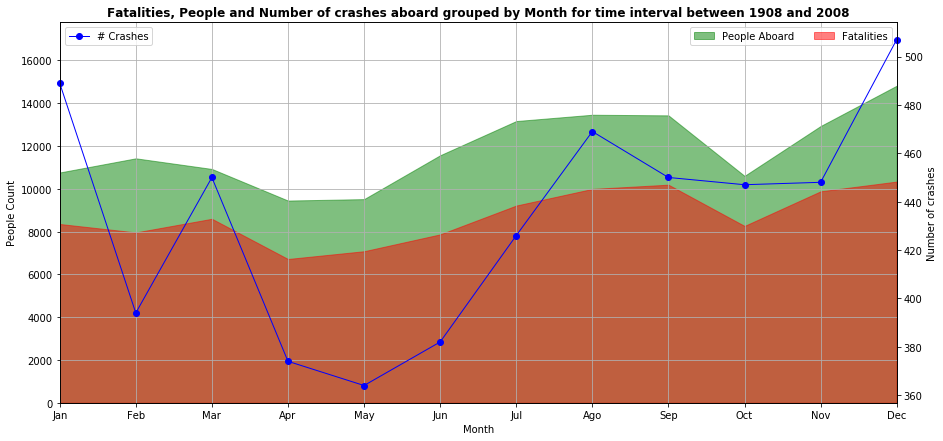

In [19]:
x=range(12)
xlabels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dec']

plt.close('all')
fig=plt.figure(figsize=(15,7))

ax=fig.add_subplot(111)
ax.fill_between(x,0,pivot_4['People Aboard'],color='green',label='People Aboard',alpha=0.5)
ax.fill_between(x,0,pivot_4['Fatalities'],color='red',label='Fatalities',alpha=0.5)
ax.set_xticks(x)
ax.set_xticklabels(xlabels)
ax.grid()
ax.legend(loc='best',ncol=2)
ax.set_xlim(0,11)
ax.set_ylim(0,max(pivot_4[['People Aboard','Fatalities']].max())*1.2)
ax.set_xlabel('Month')
ax.set_ylabel('People Count')

ax1=ax.twinx()
ax1.plot(x,pivot_4['# Crashes'],'blue',linewidth=1,marker='o',clip_on=False)
ax1.set_ylabel('Number of crashes')
ax1.legend(loc='upper left')

plt.title('Fatalities, People and Number of crashes aboard grouped by Month for time interval between 1908 and 2008',fontweight='bold')

plt.show()

There is a non linear relation between `number of crashes` and `fatalities` when grouped by Month (as seen in Case 2 and 3). When groped by Month, we also have a strong linear relation between `fatalities` and `people aboard` as we have confirmed in Case 1 and 3

___